In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, f1_score, recall_score, precision_score
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

import imblearn
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as imbpipeline

In [2]:
df = pd.read_csv('WA_Fn-UseC_-Telco-Customer-Churn.csv')

df

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,6840-RESVB,Male,0,Yes,Yes,24,Yes,Yes,DSL,Yes,...,Yes,Yes,Yes,Yes,One year,Yes,Mailed check,84.80,1990.5,No
7039,2234-XADUH,Female,0,Yes,Yes,72,Yes,Yes,Fiber optic,No,...,Yes,No,Yes,Yes,One year,Yes,Credit card (automatic),103.20,7362.9,No
7040,4801-JZAZL,Female,0,Yes,Yes,11,No,No phone service,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.60,346.45,No
7041,8361-LTMKD,Male,1,Yes,No,4,Yes,Yes,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Mailed check,74.40,306.6,Yes


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


- The dataset contains many categorical features.
- TotalCharges is a numerical feature but are stored in object/ string datatype.

# Target Variable: Churn

In [4]:
palette = 'Set2'

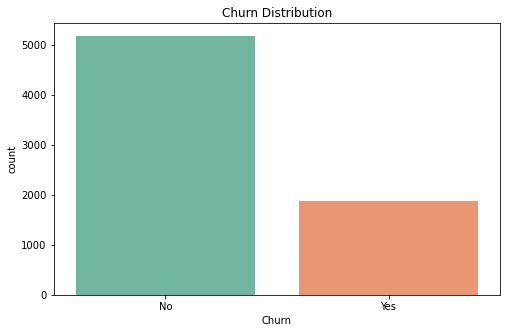

In [5]:
f, ax = plt.subplots(figsize=(8, 5)) 

sns.countplot(x = df['Churn'], palette = palette)

ax.set(xlabel="Churn")
ax.set(title="Churn Distribution")

plt.show()

- The dataset si imbalanced with a ratio around 3:1 for not churn and churn customers.
- We need to balance the churn distribution.

In [6]:
df['Churn'].replace({"Yes":1, "No":0}, inplace = True)

df

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,0
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,0
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,1
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,0
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,6840-RESVB,Male,0,Yes,Yes,24,Yes,Yes,DSL,Yes,...,Yes,Yes,Yes,Yes,One year,Yes,Mailed check,84.80,1990.5,0
7039,2234-XADUH,Female,0,Yes,Yes,72,Yes,Yes,Fiber optic,No,...,Yes,No,Yes,Yes,One year,Yes,Credit card (automatic),103.20,7362.9,0
7040,4801-JZAZL,Female,0,Yes,Yes,11,No,No phone service,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.60,346.45,0
7041,8361-LTMKD,Male,1,Yes,No,4,Yes,Yes,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Mailed check,74.40,306.6,1


# Exploratory Data Analysis

In [7]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
SeniorCitizen,7043.0,0.162147,0.368612,0.00,0.0,0.00,0.00,1.00
tenure,7043.0,32.371149,24.559481,0.00,9.0,29.00,55.00,72.00
MonthlyCharges,7043.0,64.761692,30.090047,18.25,35.5,70.35,89.85,118.75
Churn,7043.0,0.265370,0.441561,0.00,0.0,0.00,1.00,1.00


In [8]:
df.columns

Index(['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents',
       'tenure', 'PhoneService', 'MultipleLines', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling',
       'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn'],
      dtype='object')

- Categorical features: 'customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod'
- Numerical features: 'tenure', 'MonthlyCharges', 'TotalCharges'

In [11]:
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'],errors = 'coerce')

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [12]:
df.isnull().sum()

customerID           0
gender               0
SeniorCitizen        0
Partner              0
Dependents           0
tenure               0
PhoneService         0
MultipleLines        0
InternetService      0
OnlineSecurity       0
OnlineBackup         0
DeviceProtection     0
TechSupport          0
StreamingTV          0
StreamingMovies      0
Contract             0
PaperlessBilling     0
PaymentMethod        0
MonthlyCharges       0
TotalCharges        11
Churn                0
dtype: int64

In [13]:
df = df.dropna()

df.isnull().sum()

customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

## Gender 

Categorical features: 'customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod'

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


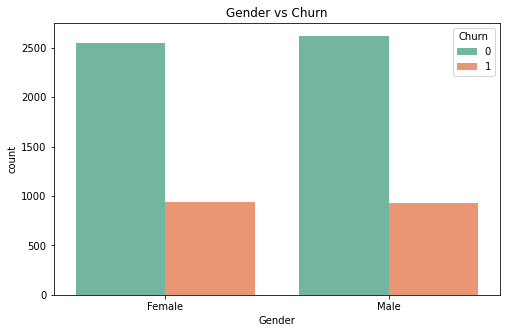

In [15]:
f, ax = plt.subplots(figsize=(8, 5)) 

sns.countplot(df['gender'], hue = df['Churn'], palette = palette)

ax.set(xlabel="Gender")
ax.set(title="Gender vs Churn")

plt.show()

Customer churn for each gender are very similar

# SeniorCitizen

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


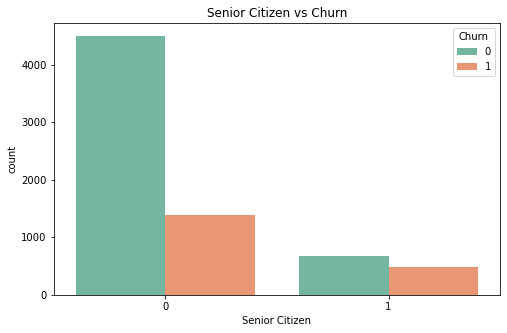

In [16]:
f, ax = plt.subplots(figsize=(8, 5)) 

sns.countplot(df['SeniorCitizen'], hue = df['Churn'], palette = palette)

ax.set(xlabel="Senior Citizen")
ax.set(title="Senior Citizen vs Churn")

plt.show()

In [17]:
pd.DataFrame(df['SeniorCitizen'].groupby(df['Churn']).count())

,SeniorCitizen
Churn,
0,5163
1,1869


- The number of senior citizen is low.
- Nearly 40% of customers churn are senior citizens.

## Partner 

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


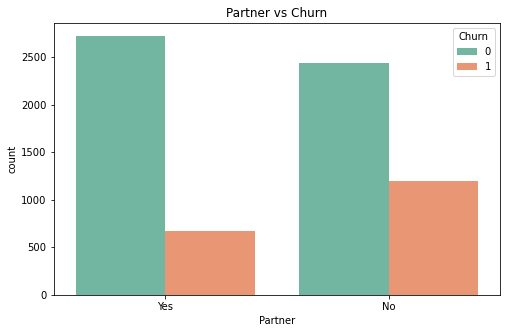

In [19]:
f, ax = plt.subplots(figsize=(8, 5)) 

sns.countplot(df['Partner'], hue = df['Churn'], palette = palette)

ax.set(xlabel="Partner")
ax.set(title="Partner vs Churn")

plt.show()

Customer who has a partner churned less than a customer who doesn't

## Dependents

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


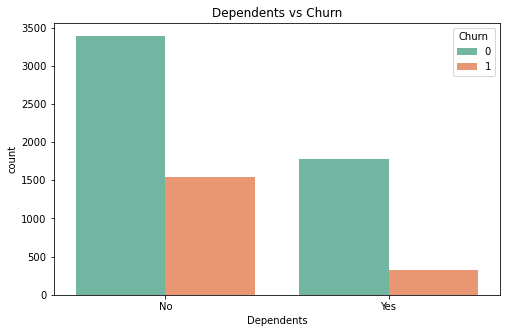

In [20]:
f, ax = plt.subplots(figsize=(8, 5)) 

sns.countplot(df['Dependents'], hue = df['Churn'], palette = palette)

ax.set(xlabel="Dependents")
ax.set(title="Dependents vs Churn")

plt.show()

Customer who has dependents churned less than a customer who doesn't

## PhoneService 

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


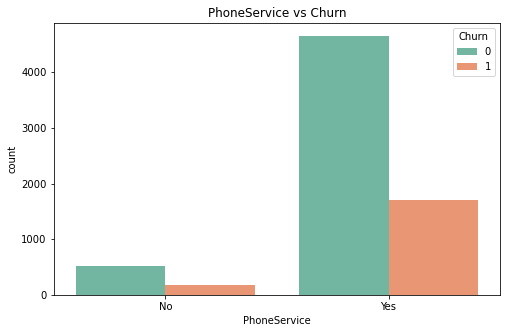

In [21]:
f, ax = plt.subplots(figsize=(8, 5)) 

sns.countplot(df['PhoneService'], hue = df['Churn'], palette = palette)

ax.set(xlabel="PhoneService")
ax.set(title="PhoneService vs Churn")

plt.show()

Despite having no phone service, there are more customers who don't churn

## MultipleLines 

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


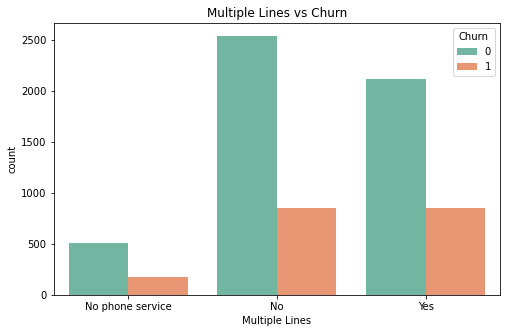

In [22]:
f, ax = plt.subplots(figsize=(8, 5)) 

sns.countplot(df['MultipleLines'], hue = df['Churn'], palette = palette)

ax.set(xlabel="Multiple Lines")
ax.set(title="Multiple Lines vs Churn")

plt.show()

For each multipleline, there are more customers who don't churn

## InternetService 

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


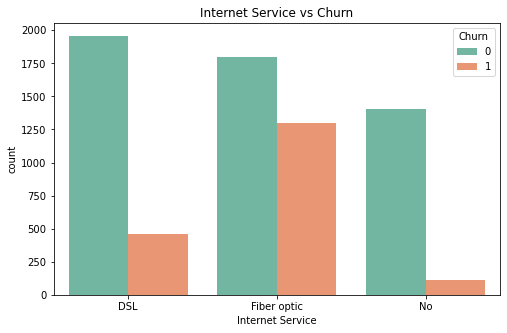

In [23]:
f, ax = plt.subplots(figsize=(8, 5)) 

sns.countplot(df['InternetService'], hue = df['Churn'], palette = palette)

ax.set(xlabel="Internet Service")
ax.set(title="Internet Service vs Churn")

plt.show()

- For each internet service, there are more customers who don't churn.
- Customers who use fiber optic internet service hve the most and a high number of churn customers.

## OnlineSecurity 

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


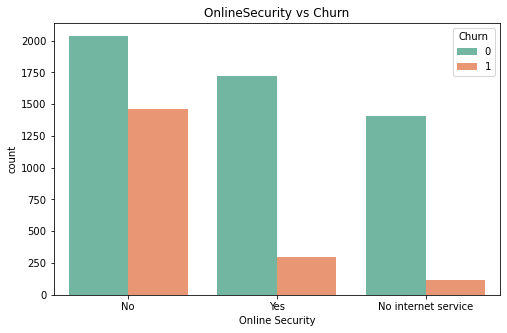

In [24]:
f, ax = plt.subplots(figsize=(8, 5)) 

sns.countplot(df['OnlineSecurity'], hue = df['Churn'], palette = palette)

ax.set(xlabel="Online Security")
ax.set(title="OnlineSecurity vs Churn")

plt.show()

- For each online security, there are more customers who don't churn.
- Customers who don't have online security have the most and a high number of churn customers.

## OnlineBackup 

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


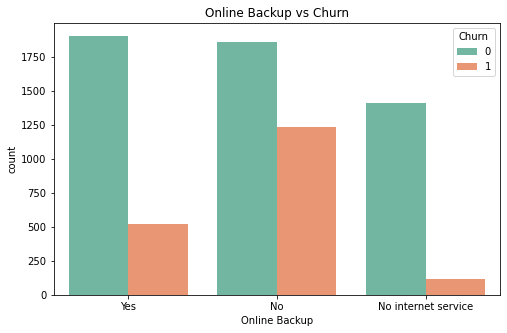

In [25]:
f, ax = plt.subplots(figsize=(8, 5)) 

sns.countplot(df['OnlineBackup'], hue = df['Churn'], palette = palette)

ax.set(xlabel="Online Backup")
ax.set(title="Online Backup vs Churn")

plt.show()

- Similar to online security, there are more customers who don't churn in each category.
- Customers who don't have online backup have the most and a high number of churn customers.

## DeviceProtection 

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


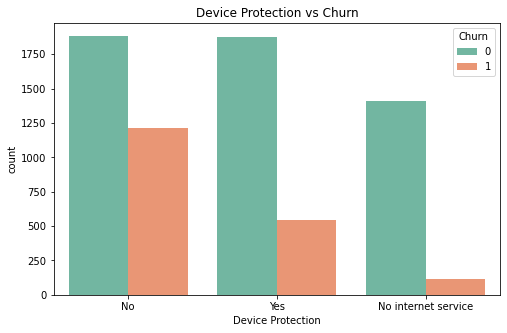

In [26]:
f, ax = plt.subplots(figsize=(8, 5)) 

sns.countplot(df['DeviceProtection'], hue = df['Churn'], palette = palette)

ax.set(xlabel="Device Protection")
ax.set(title="Device Protection vs Churn")

plt.show()

Customers who don't have device protection have the most and a high number of churn customers.

## TechSupport 

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


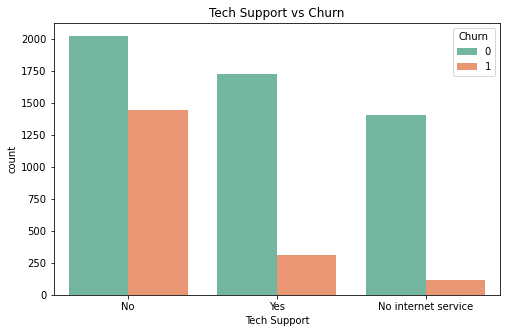

In [27]:
f, ax = plt.subplots(figsize=(8, 5)) 

sns.countplot(df['TechSupport'], hue = df['Churn'], palette = palette)

ax.set(xlabel="Tech Support")
ax.set(title="Tech Support vs Churn")

plt.show()

Customers who don't have tech support have the most and a high number of churn customers.

## StreamingTV 

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


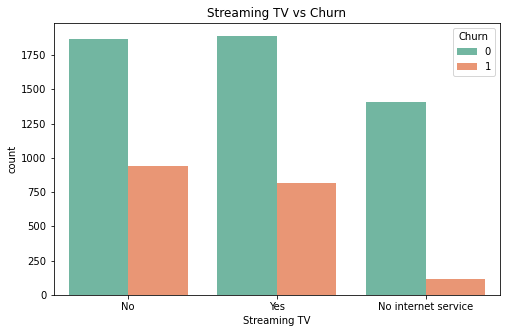

In [28]:
f, ax = plt.subplots(figsize=(8, 5)) 

sns.countplot(df['StreamingTV'], hue = df['Churn'], palette = palette)

ax.set(xlabel="Streaming TV")
ax.set(title="Streaming TV vs Churn")

plt.show()

## StreamingMovies 

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


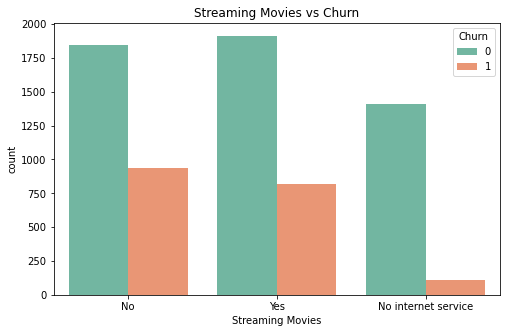

In [29]:
f, ax = plt.subplots(figsize=(8, 5)) 

sns.countplot(df['StreamingMovies'], hue = df['Churn'], palette = palette)

ax.set(xlabel="Streaming Movies")
ax.set(title="Streaming Movies vs Churn")

plt.show()

## Contract 

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


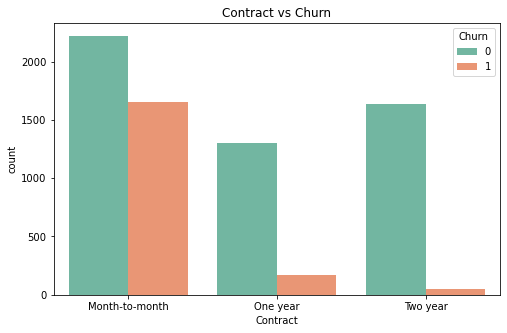

In [30]:
f, ax = plt.subplots(figsize=(8, 5)) 

sns.countplot(df['Contract'], hue = df['Churn'], palette = palette)

ax.set(xlabel="Contract")
ax.set(title="Contract vs Churn")

plt.show()

Customer churning for month-to-month contracts is quite high. Probably it happens because customers are testing Telco for one month and then they decide whether they want to renew the contract or not.

## PaperlessBilling 

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


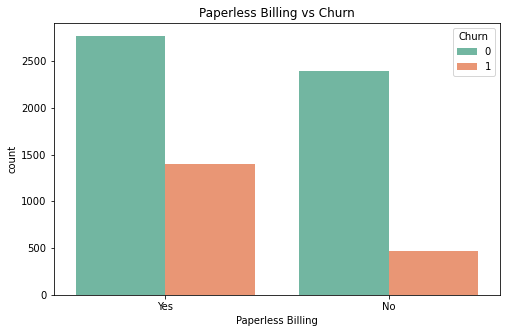

In [31]:
f, ax = plt.subplots(figsize=(8, 5)) 

sns.countplot(df['PaperlessBilling'], hue = df['Churn'], palette = palette)

ax.set(xlabel="Paperless Billing")
ax.set(title="Paperless Billing vs Churn")

plt.show()

Paperless Billing displays a high customer churn

## PaymentMethod

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


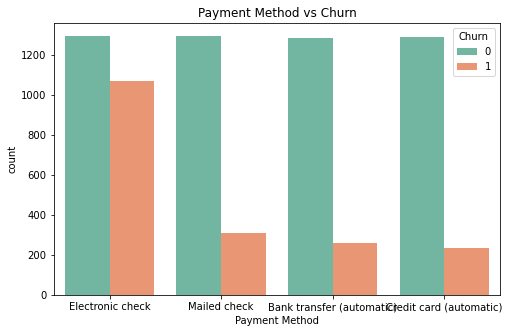

In [32]:
f, ax = plt.subplots(figsize=(8, 5)) 

sns.countplot(df['PaymentMethod'], hue = df['Churn'], palette = palette)

ax.set(xlabel="Payment Method")
ax.set(title="Payment Method vs Churn")

plt.show()

In [33]:
df['PaymentMethod'].unique()

array(['Electronic check', 'Mailed check', 'Bank transfer (automatic)',
       'Credit card (automatic)'], dtype=object)

Customers who use electronic check payment methods have the most and a high number of churn customers.

## Numerical Features 

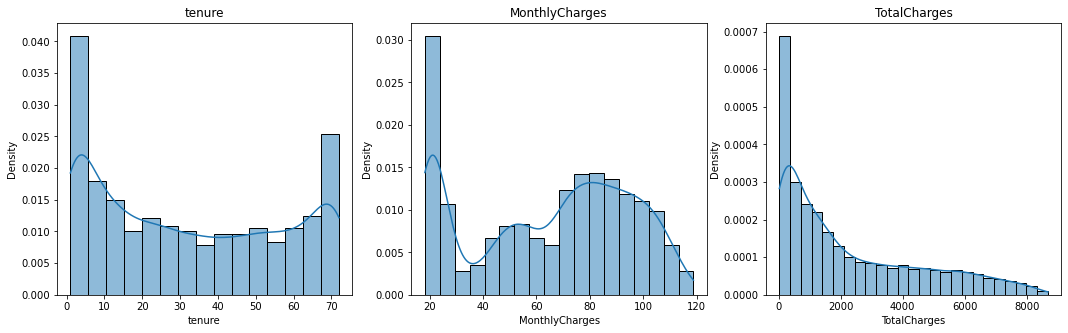

In [76]:
numeric_features = ['tenure', 'MonthlyCharges', 'TotalCharges']

fig,ax = plt.subplots(nrows=1,ncols=3,figsize=(18, 5))

col = 0

for i in numeric_features:
    sns.histplot(df[i], kde=True, stat="density", ax=ax[col], palette = palette)
    ax[col].set_title(i)
    col += 1

- Total charges displays a positively skewed distribution.
- Tenure has two peaks around 0 and 70.
- Monthly charges also displays two peaks around 20 and 80.

## MonthlyCharges

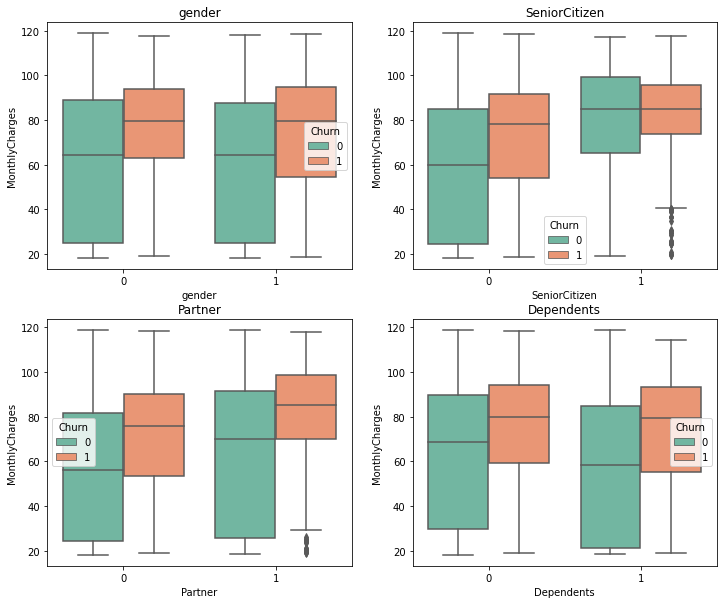

In [74]:
cust_features = ['gender', 'SeniorCitizen', 'Partner', 'Dependents']

fig,ax = plt.subplots(nrows=2,ncols=2,figsize=(12,10))

row = col = 0

for n,i in enumerate(cust_features):
    if (n%2 == 0) & (n > 0):
        row += 1
        col = 0
    sns.boxplot(data = df, x = i, y = 'MonthlyCharges', hue = 'Churn', ax=ax[row,col], palette = palette)
    ax[row,col].set_title(i)
    col += 1

## TotalCharges

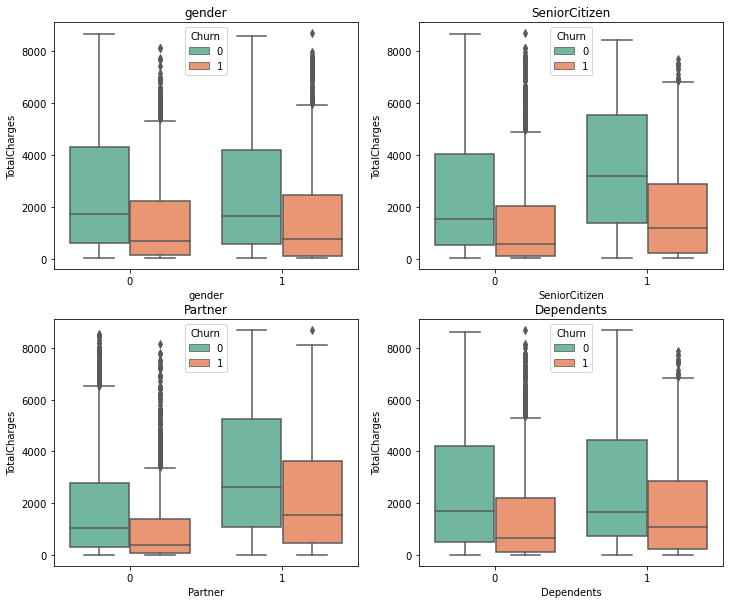

In [77]:
fig,ax = plt.subplots(nrows=2,ncols=2,figsize=(12,10))

row = col = 0

for n,i in enumerate(cust_features):
    if (n%2 == 0) & (n > 0):
        row += 1
        col = 0
    sns.boxplot(data = df, x = i, y = 'TotalCharges', hue = 'Churn', ax=ax[row,col], palette = palette)
    ax[row,col].set_title(i)
    col += 1

The minimum and maximum value of monthly and total charges from senior citizen is high. It looks like they will to pay more than non senior citizen.

# Feature Engineering

## Drop customerID 

In [34]:
df = df.drop('customerID', axis = 1)

df

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,0
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,0
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,1
3,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,0
4,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,Male,0,Yes,Yes,24,Yes,Yes,DSL,Yes,No,Yes,Yes,Yes,Yes,One year,Yes,Mailed check,84.80,1990.50,0
7039,Female,0,Yes,Yes,72,Yes,Yes,Fiber optic,No,Yes,Yes,No,Yes,Yes,One year,Yes,Credit card (automatic),103.20,7362.90,0
7040,Female,0,Yes,Yes,11,No,No phone service,DSL,Yes,No,No,No,No,No,Month-to-month,Yes,Electronic check,29.60,346.45,0
7041,Male,1,Yes,No,4,Yes,Yes,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Mailed check,74.40,306.60,1


## Label Encoding Categorical Features 

In [35]:
df.columns

Index(['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure',
       'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity',
       'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV',
       'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod',
       'MonthlyCharges', 'TotalCharges', 'Churn'],
      dtype='object')

In [36]:
categorical_features = ['gender', 'SeniorCitizen', 'Partner', 'Dependents',
       'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity',
       'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV',
       'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod']

In [37]:
le = LabelEncoder()

for i in categorical_features:
    df[i] = le.fit_transform(df[i])
    
df

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,0,0,1,0,1,0,1,0,0,2,0,0,0,0,0,1,2,29.85,29.85,0
1,1,0,0,0,34,1,0,0,2,0,2,0,0,0,1,0,3,56.95,1889.50,0
2,1,0,0,0,2,1,0,0,2,2,0,0,0,0,0,1,3,53.85,108.15,1
3,1,0,0,0,45,0,1,0,2,0,2,2,0,0,1,0,0,42.30,1840.75,0
4,0,0,0,0,2,1,0,1,0,0,0,0,0,0,0,1,2,70.70,151.65,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,1,0,1,1,24,1,2,0,2,0,2,2,2,2,1,1,3,84.80,1990.50,0
7039,0,0,1,1,72,1,2,1,0,2,2,0,2,2,1,1,1,103.20,7362.90,0
7040,0,0,1,1,11,0,1,0,2,0,0,0,0,0,0,1,2,29.60,346.45,0
7041,1,1,1,0,4,1,2,1,0,0,0,0,0,0,0,1,3,74.40,306.60,1


# Feature Correlations 

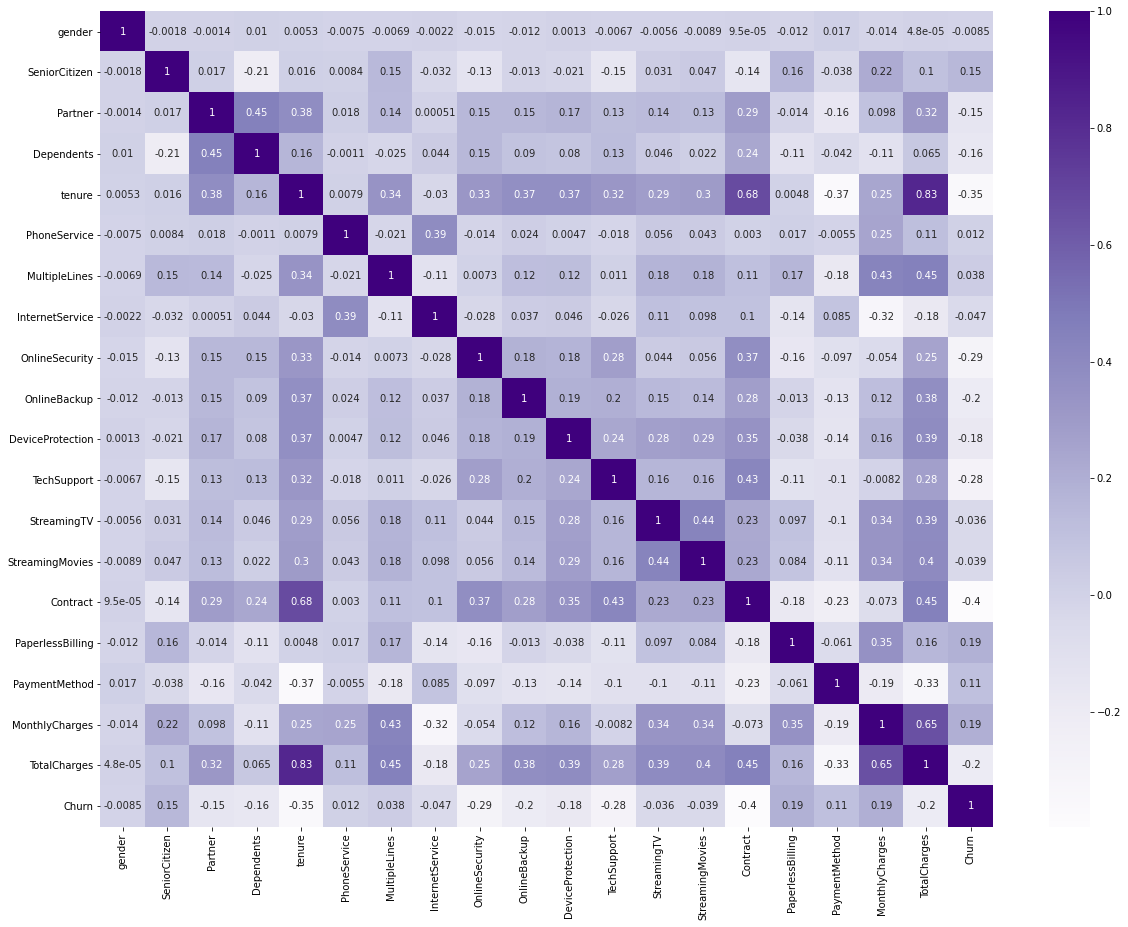

In [38]:
plt.figure(figsize = (20,15))

sns.heatmap(df.corr(), cmap='Purples', annot = True);

# Modeling

## Split Dataset 

In [39]:
X = df.drop('Churn', axis=1)
y = df['Churn']

In [40]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size = 0.2, random_state = 0)

In [42]:
stratified_kfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=0)

## Logistic Regression 

In [43]:
pipeline_lr = imbpipeline(steps = [['smote', SMOTE(random_state=0)],
                                ['scaler', MinMaxScaler()],
                                ['classifier', LogisticRegression(random_state=0)]])

In [44]:
param_lr = {'classifier__C':[0.001, 0.01, 0.1, 1, 10, 100, 1000]}
random_search_lr = RandomizedSearchCV(estimator=pipeline_lr,
                           param_distributions=param_lr,
                           scoring='roc_auc',
                           cv=stratified_kfold,
                           n_jobs=-1)

In [45]:
random_search_lr.fit(X_train, y_train)

cv_score_lr = random_search_lr.best_score_

print(cv_score_lr)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:306: UserWarning: The total space of parameters 7 is smaller than n_iter=10. Running 7 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


0.821959866023419


In [46]:
print(random_search_lr.best_params_)

{'classifier__C': 10}


In [47]:
y_pred_lr = random_search_lr.best_estimator_.predict(X_test)

classification_report(y_test, y_pred_lr)

'              precision    recall  f1-score   support\n\n           0       0.88      0.77      0.82      1033\n           1       0.52      0.71      0.60       374\n\n    accuracy                           0.75      1407\n   macro avg       0.70      0.74      0.71      1407\nweighted avg       0.78      0.75      0.76      1407\n'

In [48]:
roc_auc_score(y_test, y_pred_lr)

0.7367746711462901

## Random Forest 

In [51]:
pipeline_rf = imbpipeline(steps = [['smote', SMOTE(sampling_strategy = 1)],
                                ['scaler', MinMaxScaler()],
                                ['rf', RandomForestClassifier()]])

In [52]:
param_rf = {'rf__max_depth': [10, 20, 30],
            'rf__max_features': ['auto', 'sqrt'],
            'rf__min_samples_leaf': [1, 2, 4],
            'rf__min_samples_split': [2, 5, 10],
            'rf__n_estimators': [100, 500, 1000]}
random_search_rf = RandomizedSearchCV(estimator=pipeline_rf,
                           param_distributions=param_rf,
                           scoring='roc_auc',
                           cv=stratified_kfold,
                           n_jobs=-1)

In [53]:
random_search_rf.fit(X_train, y_train)

cv_score_rf = random_search_rf.best_score_

test_rf = random_search_rf.score(X_test, y_test)
print(f'Cross-validation score: {cv_score_rf}\nTest score: {test_rf}')

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


Cross-validation score: 0.8326918682719904
Test score: 0.8332487795787151


In [54]:
y_pred_rf = random_search_rf.predict(X_test)

classification_report(y_test, y_pred_rf)

'              precision    recall  f1-score   support\n\n           0       0.87      0.81      0.84      1033\n           1       0.57      0.67      0.61       374\n\n    accuracy                           0.78      1407\n   macro avg       0.72      0.74      0.73      1407\nweighted avg       0.79      0.78      0.78      1407\n'

In [55]:
roc_auc_score(y_test, y_pred_rf)

0.7421442659612467

## Xgboost 

In [56]:
pipeline_xgbc = imbpipeline(steps = [['smote', SMOTE(sampling_strategy = 1)],
                                ['scaler', MinMaxScaler()],
                                ['xgbc', XGBClassifier()]])

In [57]:
param_xgbc = {'xgbc__gamma': [0,0.1,0.2,0.4],
              'xgbc__learning_rate': [0.01, 0.1, 0.15],
              'xgbc__max_depth': [8, 10],
              'xgbc__n_estimators': [100, 500, 1000]}
random_search_xgbc = RandomizedSearchCV(estimator=pipeline_xgbc,
                           param_distributions=param_xgbc,
                           scoring='roc_auc',
                           cv=stratified_kfold,
                           n_jobs=-1)

In [58]:
random_search_xgbc.fit(X_train, y_train)

cv_score_xgbc = random_search_xgbc.best_score_

test_xgbc = random_search_xgbc.score(X_test, y_test)
print(f'Cross-validation score: {cv_score_xgbc}\nTest score: {test_xgbc}')

Cross-validation score: 0.8178557699293618
Test score: 0.8188418551438881


In [59]:
y_pred_xgbc = random_search_xgbc.predict(X_test)

classification_report(y_test, y_pred_xgbc)

'              precision    recall  f1-score   support\n\n           0       0.85      0.83      0.84      1033\n           1       0.55      0.58      0.57       374\n\n    accuracy                           0.76      1407\n   macro avg       0.70      0.71      0.70      1407\nweighted avg       0.77      0.76      0.77      1407\n'

In [60]:
roc_auc_score(y_test, y_pred_xgbc)

0.7058862355115415